# Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization

## Imports

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image

from plot_tools import *

## Training of the decoder

### Datasets

In [2]:
from dataset import CIFAR10, ArtBench10
from torch.utils.data import DataLoader
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# datasets
cifar10_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
artbench_dataset = ArtBench10(root='./data', train=True, transform=transform, download=True)

# choose the size of the training dataset
size = 512
indices = list(range(size))
cifar10_dataset = Subset(cifar10_dataset, indices)
artbench_dataset = Subset(artbench_dataset, indices)

# create the dataloaders
cifar10_loader = DataLoader(cifar10_dataset, batch_size=64, shuffle=True)
artbench_loader = DataLoader(artbench_dataset, batch_size=64, shuffle=True)

print("len(cifar10_dataset) =", len(cifar10_dataset), "images")
print("len(artbench_dataset) =", len(artbench_dataset), "images")

print("len(cifar10_loader) =", len(cifar10_loader), "batches")
print("len(artbench_loader) =", len(artbench_loader), "batches")

Files already downloaded and verified
Files already downloaded and verified
len(cifar10_dataset) = 64 images
len(artbench_dataset) = 64 images
len(cifar10_loader) = 1 batches
len(artbench_loader) = 1 batches


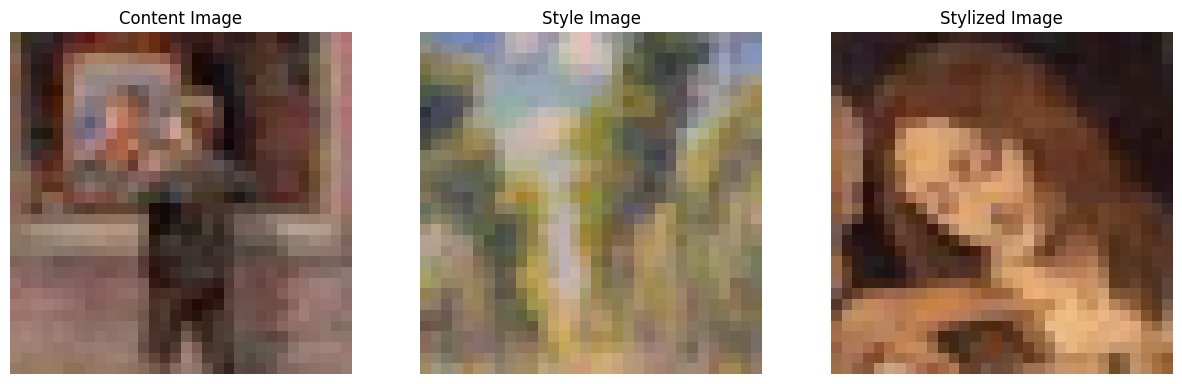

In [3]:
# Watch some images

from plot_tools import *

for img in cifar10_loader :
    #plot_img(img[0][0],img[0][1])
    break
for img in artbench_loader :
    plot_img(img[0][0],img[0][1], img[0][2])
    break

## Define the model

In [3]:
from model import StyleTransfer
lr = 3e-4
lam = 2.
model = StyleTransfer(lr=lr, lam=lam)

Using cache found in /Users/gurvanrichardeau/.cache/torch/hub/pytorch_vision_v0.9.0
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training the decoder

In [5]:
# Training
nb_epochs = 2
model.train_decoder(content_loader=cifar10_loader, style_loader=artbench_loader, nb_epochs=2)


Epoch : 1 Loss : 44471.6484: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


### Plot Loss

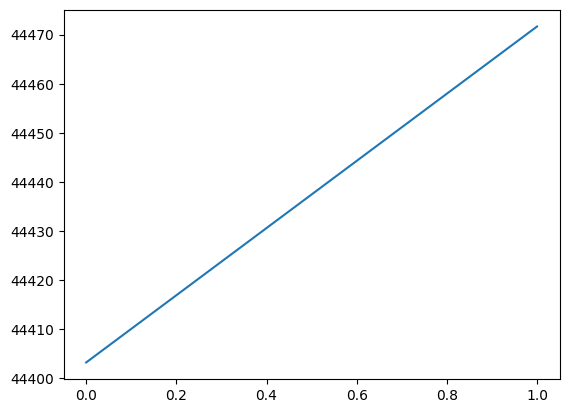

In [6]:
plt.plot(model.LOSS)

### Saving model

In [7]:
# Will automatically be saved into the saving_path : 'model_checkpoints/Adain/' 
model.save()

### Loading model to retrain it

The loading is carried out in such a way that the era returns to where it was, and the list of all losses is continued and not overwritten.

In [11]:
model = StyleTransfer(lr, lam)
checkpoint_epoch = 2 # Choose which model you want to load, see them in the saving_path : 'model_checkpoints/Adain/'

model.load(epoch=checkpoint_epoch)

model.train_decoder(content_loader=cifar10_loader, style_loader=artbench_loader, nb_epochs=2)

Using cache found in /Users/gurvanrichardeau/.cache/torch/hub/pytorch_vision_v0.9.0
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch : 3 Loss : 43042.8281: 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]


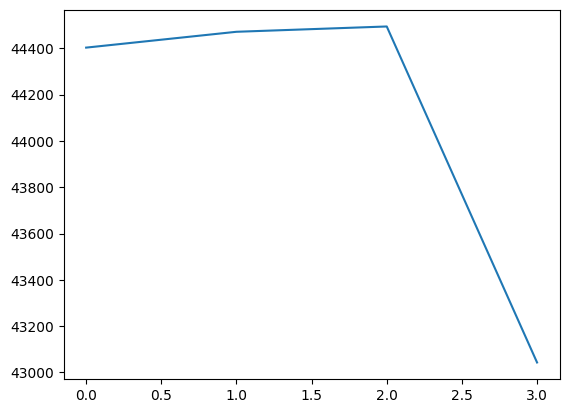

In [14]:
plt.plot(model.LOSS)

# Evaluating the model

## Load and preprocess the images

In [27]:
# Load the content and style images
content_img = Image.open("images/content/golden_gate.jpg")
style_img = Image.open("images/style/sketch.png")

# Preprocess the images
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

content_tensor = preprocess(content_img).unsqueeze(0)
style_tensor = preprocess(style_img).unsqueeze(0)

print("content_tensor:", content_tensor.shape)
print("style_tensor:", style_tensor.shape)

#transforms.ToPILImage()(content_tensor.squeeze(0).cpu().clamp(0, 1)).show()
#transforms.ToPILImage()(style_tensor.squeeze(0).cpu().clamp(0, 1)).show()

content_tensor: torch.Size([1, 3, 32, 32])
style_tensor: torch.Size([1, 3, 32, 32])


## Load and Run the model

In [28]:
model = StyleTransfer()
checkpoint_epoch = 2
model.load(checkpoint_epoch)

with torch.no_grad():
    stylized_img = model(content_tensor, style_tensor)

## Print the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


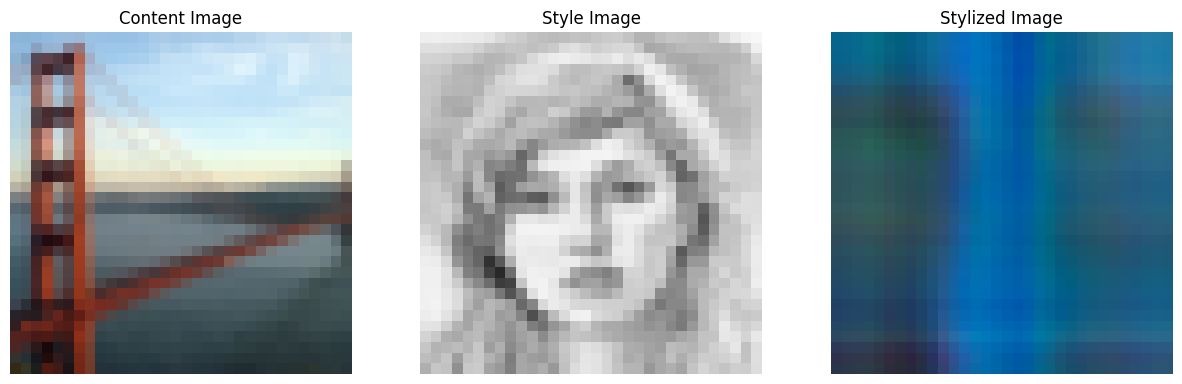

In [34]:
plot_img(content_tensor, style_tensor, stylized_img)